# 모듈 로딩

In [1]:
import argparse
import torch
import os
import json
import itertools

from utils.util import ensure_dir

import numpy as np
import pandas as pd

from utils.util import get_instance
from utils.visualization import visualization, confusion_matrix_visualization
import model.model as module_arch

from data_loader.data_loaders import test_data

# 사용자 입력 설정

In [8]:
args_checkpoint = "./saved/models/0404_211908_cv/model_best.pth"
args_testfile = "./data/test_16_7-5.csv" # data_filepath = 
args_lithology = "lithology.csv"
args_device = "0"
args_outpath = None
args_indicator = "16_7-5"

# 실험 변수 설정

In [9]:
if args_checkpoint:
    config = torch.load(args_checkpoint)["config"]
if args_device:
    os.environ["CUDA_VISIBLE_DEVICES"] = args_device

outpath = os.path.join("./test_output", "" if args_outpath is None else args_outpath)
ensure_dir(outpath)

# import test dataset

in_features   = config["data_loader"]["args"]["in_features"]
out_feature   = config["data_loader"]["args"]["out_feature"]
lithology = "lithology.csv"

depth_name = config["tensor_loader"]["args"]["depth_name"]
max_depth = config["tensor_loader"]["args"]["max_depth"]

chunk_depth = config["arch"]["args"]["chunk_depth"]
batch_size = config["tensor_loader"]["args"]["batch_size"]
shuffle = config["tensor_loader"]["args"]["shuffle"]

# load scaler from checkpoint
checkpoint = torch.load(args_checkpoint)
state_dict = checkpoint["state_dict"]
scaler     = checkpoint["scaler"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로딩
'*data_loader/data_loader.py*' 모듈 호출을 통해 test할 데이터를 전처리 후 반환한다. 현재 수행하는 전처리로는 결측값 제외, 정규화 등이 있다. 이런게 전처리된 데이터들은 사전에 훈련한 모델로 예측을 진행한다.

In [10]:
loader, output_df = test_data(  data_filepath = args_testfile
                              , in_features = in_features
                              , out_feature = out_feature
                              , depth_name = depth_name
                              , max_depth = max_depth
                              , chunk_depth = chunk_depth
                              , batch_size = batch_size
                              , shuffle = shuffle
                              , scaler = scaler
                              , lithology = lithology
                              )

Loading Data....


# 모델 빌드
lith 모델을 생성하고, 이와 동시에 기존에 학습해 두었던 모델의 학습된 weights 값들을 불러와 새로 생성된 모델에 입력한다.

In [11]:
# build model architecture
model = get_instance(module_arch, "arch", config)

# load weights from the trained model
if config["n_gpu"] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)
model  = model.to(device)

# Run

In [12]:
# predict test data
pred_list = np.empty( output_df.shape[0] )
with torch.no_grad():
    for batch_idx, (data, target) in enumerate( loader ):
        data = data.to(device)
        output = model(data)

        predicted = torch.max(output, 1)[1].cpu().numpy()
        if batch_idx == 0:
            pred_list = predicted
            label_list = target.numpy()
        else:
            pred_list = np.concatenate( [pred_list, predicted] )
            label_list = np.concatenate( [label_list, target.numpy()] )

output_df["label"] = label_list
output_df["pred"]  = pred_list

output_df.to_csv(os.path.join(outpath, "predict") + '_{:}.csv'.format(args_indicator), index=False)

# 평가
정량적 평가 및 정성적 평가를 진행한다.

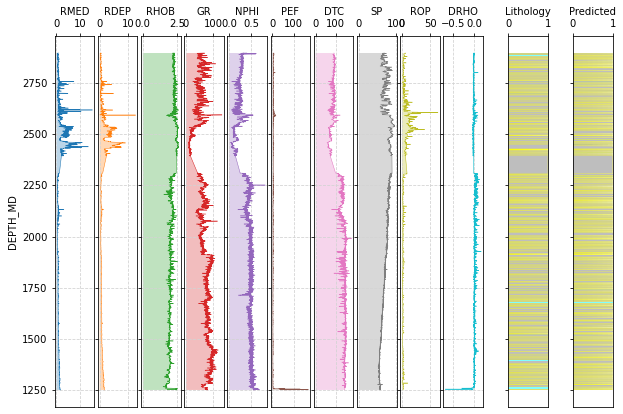

In [13]:
# qualitative evaluation
features = [ feature for feature in in_features if feature != depth_name]
visualization(df = output_df, features = features, depth_name = depth_name)

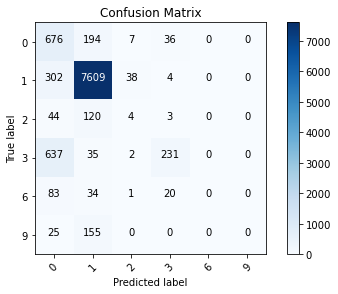

Accuracy:  83.04


In [18]:
# quantitative evaluation
confusion_matrix_visualization( df = output_df)

acc = round( 100*sum(output_df["label"] == output_df["pred"])/output_df.shape[0], 2 )
print( "Accuracy: ", acc )